In [80]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
from datetime import datetime
import datetime
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder #2020.09.22 정혜인 추가
from sklearn.model_selection import train_test_split
from matplotlib import font_manager, rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
import platform
plt.rc('font', family='NanumBarunGothic') 

from sklearn.ensemble import RandomForestRegressor

import matplotlib.font_manager as fm
#fm._rebuild()
plt.rc('font', family='NanumBarunGothic') 

import lightgbm as lgb

In [2]:
def make_cast_time(train): # nan값이 있는 초기 데이터셋을 써야 하기 때문에 가장 먼저 돌려줍니다. 자세한 알고리즘은 창고에서 찾아보세요.

    # 일단 nan값을 노출칼럼에만 남기기 위해서 나머지 nan값 전처리 미리 해버리겠습니다.
    train['취급액'] = train['취급액'].fillna('0')
    train = train[train.상품군 != '무형']

    # nan값 있는 애들을 따로 저장해둡니다.
    train_yes_nan = train[train['노출(분)'].isnull()]
    # nan값 없는 애들을 따로 저장해줍니다. 이놈들로 작업할겁니다.
    train_not_nan = train.dropna()

    # 인덱스 꼬여서 포문 안 돌아가기 때문에 인덱스 리셋하고 나중에 불러와주기 위해서 따로 저장해줍니다.
    train_not_nan_index = train_not_nan.index
    # 리셋 인덱스 해줍니다.
    train_not_nan_reset_index = train_not_nan.reset_index(drop=True)

    # 여기서부터 cast_time, cast_count 포문-----------------------------------------------------
    cast_time = []
    cast_count = []
    time = 0.
    count = 1

    for i in range(len(train_not_nan_reset_index)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i-1]: # 자기의 상품코드가 앞행의 상품코드와 같을 때
            time += train_not_nan_reset_index['노출(분)'][i] # 기존 누적된 노출에 자기 노출을 더한다.
            count += 1 # count도 1을 더해줍니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        else: # 근데 자기 상품코드와 앞행의 상품코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
    # 포문 끝------------------------------------------------------------  
    # 컬럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time'] = cast_time
    train_not_nan_reset_index['cast_count'] = cast_count
    
    # 여기서부터 cast_time_sum, cast_count_sum 포문-------------------------------------------------
    cast_time_sum = []
    cast_count_sum = []

    for i in range(len(train_not_nan_reset_index)):
        if i == max(train_not_nan_reset_index.index): #마지막은 비교할 다음타자가 없으니 바로 넣기.
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i+1]: # 자기와 다음타자의 상품코드가 같으면
            cast_time_sum.append(np.nan)
            cast_count_sum.append(np.nan)
        else: # 자기와 다음타자의 상품코드가 다르면
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
            
    # 포문 끝----------------------------------------------------------------------
    # 칼럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time_sum'] = cast_time_sum
    train_not_nan_reset_index['cast_count_sum'] = cast_count_sum
    # 백필로 nan값 채워줍니다.
    train_not_nan_reset_index.fillna(method='bfill', inplace=True)
    

    # 원래 인덱스 다시 넣어줍니다.
    train_not_nan_reset_index.index = train_not_nan_index
    # 컨캣으로 밑으로 붙여주고,
    train_concat = pd.concat([train_not_nan_reset_index, train_yes_nan], axis=0)
    # 소트 인덱스 먼저 하고,
    train_concat_sort_index = train_concat.sort_index()
    # ffill 로 채워줍니다. 끝. 이거 너무 힘들었다 진짜 레알.
    train = train_concat_sort_index.fillna(method='ffill')
    
    # 누적 방송 시간 비율 칼럼을 만들어줍니다.
    train['cast_time_ratio'] = train.cast_time / train.cast_time_sum
    
    # 인덱스 리셋해줍니다.
    train = train.reset_index(drop=True)
    
    # 다이어트
    train['cast_count'] = train.cast_count.astype(np.int16)
    
    return train

# 기본 전처리 함수
def preprocessing_1(df):
    
    # 취급액과 판매단가 수치형 변수로 바꾸기.
    df['취급액'] = df['취급액'].apply(lambda x: x.replace(',', ''))
    df['판매단가'] = df['판매단가'].apply(lambda x: x.replace(',', ''))
    df['취급액'] = df['취급액'].astype(np.int32)
    df['판매단가'] = df['판매단가'].astype(np.int32)
    
    # 칼럼명 너무 어려우니까 쪼금만 바꿔줍니다.
    #df = df.rename(columns = {' 취급액 ':'취급액'})
    
    return df

# 상품명 전처리 함수
def preprocessing_3(train):
    # 1. 일시불/무이자/없음
    train.loc[train['상품명'].str.contains('일시불') == True, "상품명_plan"] = '1'
    train.loc[train['상품명'].str.contains('일\)') == True, "상품명_plan"] = '1'
    train.loc[train['상품명'].str.contains('무이자') == True, "상품명_plan"] = '2'
    train.loc[train['상품명'].str.contains('무\)') == True, "상품명_plan"] = '2'
    train['상품명_plan'] = train['상품명_plan'].fillna('0')

    # 2. 추가구성/단품구성
    train.loc[train['상품명'].str.contains('\+') == True, "상품명_add"] = '1'
    train['상품명_add'] = train['상품명_add'].fillna('0')

    # 3. 기타/삼성/LG
    train.loc[train['상품명'].str.contains('삼성') == True, "상품명_maker"] = '1'
    train.loc[train['상품명'].str.contains('LG') == True, "상품명_maker"] = '2'
    train['상품명_maker'] = train['상품명_maker'].fillna('0')

    # 4. 세트구성/단품구성
    train.loc[train['상품명'].str.contains('세트') == True, "상품명_set"] = '1'
    train['상품명_set'] = train['상품명_set'].fillna('0')

    # 5. 여성/남성/없음
    train.loc[train['상품명'].str.contains('여성') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('브라') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('란쥬') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('블라우스') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('밍크') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('남성') == True, "상품명_sex"] = '2'
    train.loc[train['상품명'].str.contains('드로즈') == True, "상품명_sex"] = '2'
    train.loc[train['상품명'].str.contains('트렁크') == True, "상품명_sex"] = '2'
    train['상품명_sex'] = train['상품명_sex'].fillna('0')
    
    # 6. 아동/성인
    train.loc[train['상품명'].str.contains('주니어') == True, "상품명_kid"] = '1'
    train.loc[train['상품명'].str.contains('여아') == True, "상품명_kid"] = '1'
    train.loc[train['상품명'].str.contains('남아') == True, "상품명_kid"] = '1'
    train.loc[train['상품명'].str.contains('아동') == True, "상품명_kid"] = '1'
    train['상품명_kid'] = train['상품명_kid'].fillna('0')

    # category로 형변환해서 다이어트 시켜줍니다.
    train['상품명_plan'] = train['상품명_plan'].astype('category')
    train['상품명_add'] = train['상품명_add'].astype('category')
    train['상품명_maker'] = train['상품명_maker'].astype('category')
    train['상품명_set'] = train['상품명_set'].astype('category')
    train['상품명_sex'] = train['상품명_sex'].astype('category')
    
    return train

def make_fake_weight(train):
    fake_weight = []
    weight = 1

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 1 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] < train['판매단가'][i-1]: # 자기의 단가가 앞행의 것보다 작으면(같으면 안됨)
                weight +=1 # 가중치 1을 더하고,
                fake_weight.append(weight) # 그리고 어펜드
            else: # 자기의 단가가 앞행의 것과 같거나 더 크면(더 클 수는 없음.)
                weight = 1 # 가중치 1로 초기화
                fake_weight.append(weight)
                
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 1 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight'] = fake_weight
    train['fake_weight'] = train.fake_weight.apply(lambda x: -(x*x))
    
    return train

def make_train_fake(train):
    
    # 더 정확한 변수 생성을 위해 기계가 걸러내지 못하는 조건을 쳐내줍니다.
    train_fake = train[train.상품명_plan == '0'] # 할부플랜이 다른 애들 쳐내기
    train_fake = train_fake[train_fake.상품명_sex == '0'] # 성별이 다른 애들 쳐내기.
    
    # 포문 돌리기 위해 인덱스 리셋 해줍니다.
    train_fake.reset_index(drop=True, inplace=True)

    return train_fake

def make_fake_weight2(train):
    fake_weight = []
    weight = 0

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 0 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] == train['판매단가'][i-1]: # 자기의 단가가 앞행의 것과 같을 때
                if train['방송일시'][i] == train['방송일시'][i-1]:
                    if train['상품코드'][i] != train['상품코드'][i-1]: # 상품코드는 일치하지 않으면 조건 성립
                        weight -=1 # 가중치 1을 빼고,
                        fake_weight.append(weight) # 그리고 어펜드
                    else: # 상품코드까지 같으면 동일 상품.
                        weight = 0
                        fake_weight.append(weight)
                else: #방송일시가 다르면 새로운 방송 시작
                    weight = 0 # 가중치 0로 초기화
                    fake_weight.append(weight)
            else: # 판매단가가 다르면 다른 상품
                weight = 0 # 가중치 0로 초기화
                fake_weight.append(weight)
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 0 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight2'] = fake_weight
    
    return train

def preprocessing_to_merge(df):
    # merge를 위해 datetime으로 바꿔줍니다..
    df['방송일시'] = pd.to_datetime(df['방송일시'], errors='coerce')
    df['방송일시'] = df['방송일시'].astype(str)
    
    # key 칼럼을 만들어줍니다. 방송일시만으로는 안되니, 방송일시+상품명을 해줍니다.
    df['key'] = df['방송일시'] + df['상품명']
    
    return df

def preprocessing_merging(df1, df2):
    # df1이 왼쪽, df2가 오른쪽입니다.
    df3 = pd.merge(df1, df2[['key','ratings_mean','cat1','cat2','cat3']], how='left', on=['key'])
    df3 = df3.drop('key', axis=1) # key 칼럼은 드랍.
    
    return df3

# 방송일시 쪼개기 전처리 함수
def preprocessing_4(train):
    # datetime으로 바꿔줍니다.
    train['방송일시'] = pd.to_datetime(train['방송일시'], errors='coerce')
   
    # 월일이 다음날로 넘어가는 것을 막기 위해서 3시간씩 앞으로 땡겨줍니다. 마지막에 다시 더해줘야 합니다.
    delta = datetime.timedelta(hours=3)
    train['방송일시'] = train.방송일시.apply(lambda x: x - delta)

    # dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
    # 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
    train["방송일시_dow"] = train["방송일시"].dt.dayofweek

    # 요일 외에 다른 정보를 가져오기 위해서 다시 string으로 바꿔줍니다.
    train['방송일시'] = train.방송일시.astype(str)

    # MMDDhhmm 정보를 가져옵니다.
    train['방송일시_MM'] = train['방송일시'].apply(lambda x: x[5:7])
    train['방송일시_DD'] = train['방송일시'].apply(lambda x: x[8:10])
    train['방송일시_hh'] = train['방송일시'].apply(lambda x: x[11:13])
    train['방송일시_mm'] = train['방송일시'].apply(lambda x: x[14:16])

    # schedule 관련 칼럼을 더 만들어보겠습니다. # MMDD # DDHH # HHMM # weekday/weekends
    train['방송일시_MMDD'] = train['방송일시_MM'] + train['방송일시_DD']
    train['방송일시_DDhh'] = train['방송일시_DD'] + train['방송일시_hh']
    train['방송일시_hhmm'] = train['방송일시_hh'] + train['방송일시_mm']
    train['방송일시_MMDDhh'] = train['방송일시_MM'] + train['방송일시_DD'] + train['방송일시_hh']

    # mmmm_1 은 1일 사이클로 분단위로 환산한 것
    # mmmm_2 는 1달 사이클로 분단위로 환산한 것
    # mmmm_3 는 1년 사이클로 분단위로 환산한 것
    train['방송일시_mmmm_1'] = train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_2'] = train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_3'] = train['방송일시_MM'].astype(int) * train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60

    # weekday = 1 / weekends = 0
    train.loc[train.방송일시_dow == 5, '방송일시_dow2'] = '0'
    train.loc[train.방송일시_dow == 6, '방송일시_dow2'] = '0'
    train['방송일시_dow2'] = train.방송일시_dow2.fillna('1')
    
    #다이어트
    train['방송일시_dow'] = train.방송일시_dow.astype(np.int16)
    train['방송일시_MM'] = train.방송일시_MM.astype('category')
    train['방송일시_DD'] = train.방송일시_DD.astype('category')
    train['방송일시_hh'] = train.방송일시_hh.astype('category')
    train['방송일시_mm'] = train.방송일시_mm.astype('category')
    train['방송일시_MMDD'] = train.방송일시_MMDD.astype('category')
    train['방송일시_DDhh'] = train.방송일시_DDhh.astype('category')
    train['방송일시_hhmm'] = train.방송일시_hhmm.astype('category')
    train['방송일시_dow2'] = train.방송일시_dow2.astype('category')
    
    return train

def pre_nlp(train):
    # 제품명에서 불필요한 요소 전처리
    new_product_name = []

    re_stop = re.compile("""\([가-힣]{1,5}\+[가-힣]{1,5}\)|\(?무이자\)?\s?|\(?일시불\)?\s?|\(?초특가\)?\s?|\(?무\)\s?|\(?유\)\s?|\(?일\)\s?|무료체험|
    |포함|국내[가-힣]+\s|무료설치|\s?신제품\s?|\s?패키지\s?|[0-9]+종|풀코디|set|SET|풀세트|[0-9]+세트|더블팩|싱글팩|[0-9]{1,2}\+[0-9]{1,2}|[0-9]{1,2}인용|[0-9]{1,2}박스|[0-9\.]{1,4}미터|[0-9\.]{1,4}kg|[0-9\.]{1,4}[kKgG]|[0-9]{1,3}[벌롤종단구대P개통병포미봉팩장gL매]|
    |\s[0-9\.]{1,4}[Mm]|\(.{1,10}\)$|^\(.?\)|^[0-9]{2,4}\s|\s+[0-9]{2,4}\s|[0-9]{2,4}년\s|[0-9]{2,4}년형\s|시즌[0-9]|[0-9]{1,3}\%|\(.{1,20}\)$|기본형|고급형|오리지널|[대중소大中小]형|.{1,10}by|,|\s?총[0-9\s]|^[가-힣a-zA-Z]{3,3}의|
    |S\/S|F\/W|f\/w|s\/s|[가-힣]+형\s|[슈퍼]{0,2}싱글|\s[SQK퀸킹]{1,2}\s|[SQK퀸킹]{1,2}$|[가-힣]{0,2}사이즈""")

    remnants = re.compile('[",g\+lL-]\s|ml|_|\sx|[\[\]\］!"#$%&\'()*+,./:;<=>?@\^_`{|}~-]|\s종$|\s[0-9]+\s|\s{2,}')

    for i in train.상품명:
        tmp = re_stop.sub(' ',i)
        tmp = tmp.strip()
        tmp = remnants.sub(' ',tmp)
        new_product_name.append(tmp.strip())
    
    train['new_상품명'] = new_product_name
    
    # 상품명에서 브랜드 추출
    train['상품명_brand'] = train['new_상품명'].apply(lambda x: x[:2])
    
    return train

def outside_feature_naver(train, naver):
    # 먼저 합쳐줍니다.
    train = pd.merge(train, naver, on='상품명', how='left')
    
    # 전처리 해줍니다.
    train['review_counts'] = train['review_counts'].fillna(0)
    train['internet_price'] = train['internet_price'].fillna(0)
    train['review_counts'] = train['review_counts'].astype(str)
    train['internet_price'] = train['internet_price'].astype(str)
    train['review_counts'] = train['review_counts'].apply(lambda x: x.replace(',',''))
    train['internet_price'] = train['internet_price'].apply(lambda x: x.replace(',',''))
    train['internet_price'] = train['internet_price'].apply(lambda x: x.replace('원',''))
    train['review_counts'] = train['review_counts'].astype(int)
    train['internet_price'] = train['internet_price'].astype(int)

    # 오차를 컬럼으로 만들어줍니다.
    train['price_minus'] = train['판매단가'] - train['internet_price']

    # 네이버에 서칭이 되는지 여부를 알려줍니다.
    train['search_naver'] = train['internet_price'] + train['review_counts']
    train['search_naver'] = train['search_naver'].apply(lambda x: 0 if x == 0 else 1)
    
    return train

def outside_feature_weather(weather):
    # datetime으로 바꿔줍니다.
    weather['date'] = pd.to_datetime(weather['date'], errors='coerce')

    # 월일이 다음날로 넘어가는 것을 막기 위해서 3시간씩 앞으로 땡겨줍니다. 마지막에 다시 더해줘야 합니다.
    delta = datetime.timedelta(hours=3)
    weather['date'] = weather.date.apply(lambda x: x - delta)

    # 요일 외에 다른 정보를 가져오기 위해서 다시 string으로 바꿔줍니다.
    weather['date'] = weather.date.astype(str)
    
    # key column 만들어주기.
    weather['방송일시_MMDDhh'] = weather['date'].apply(lambda x: x[5:7]) + weather['date'].apply(lambda x: x[8:10]) + weather['date'].apply(lambda x: x[11:13])

    # 필요없는 칼럼은 미리 버려줍니다.
    weather.drop(['location_id', 'location', 'date'], axis=1, inplace=True)
    
    return weather

def stock_crawler(code):

    for c, i in zip(code, range(len(code))):
        
        url = 'https://finance.naver.com/item/sise_day.nhn' # URL은 고정
        result = []
        tdtext_list = ['날짜', c]

        for num in range(16, 43): # 페이지 범위 지정
            params = {'code' : c, # 지수 코드 지정
                      'page' : f'{num}'}

            resp = requests.get(url, params = params)
            soup = BeautifulSoup(resp.content, 'html.parser')

            for tr in soup.find_all('tr')[2:14]:
                new_dict = { }
                td_list = tr.find_all('td')
                if not td_list[0].text.strip():
                    continue
                for i in range(2):
                    new_dict[tdtext_list[i]] = td_list[i].text.strip()
                result.append(new_dict)

        globals()['stock_{}'.format(c)] = pd.DataFrame(result, columns = tdtext_list)
        
# 라벨인코딩 숫자가 많아지니 함수로 만들어버립니다.
def label_encoding(train_, columns, number):
    length = range(number)
    for c, i in zip(columns, length):
        # 라벨인코더 피팅
        globals()['encoder_{}:'.format(i)] = LabelEncoder()
        globals()['encoder_{}:'.format(i)].fit(train_[c].values)
        
        # 트레인셋에 트랜스폼
        train_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(train_[c])

#2020.09.22 정혜인 수정
#RF에서는 대소로 인식하므로, 원핫인코딩을 한다
def onehot_encoding(train_, columns_):
    train_ =  pd.get_dummies(train_, columns = columns_)
    return train_

#2020.09.22 정혜인 추가 (Mean Encoding)
def mean_encoding(train_, columns_):
    for i in columns_:
        mean =  train_.groupby(col)['취급액'].mean()
        col_name = str(col)+"_mean"
        train_[col_name] = train_[col].map(mean) 
    return train_
    
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [3]:
pd.set_option('display.max_columns', None)

train = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')
ratings = pd.read_csv('tv_new.csv')
category = pd.read_csv('categorized_HJ2.csv') # 카테고리 추가되었습니다.

# 난 값 먼저 채워 줍니다.
category['cat3'] = category.apply(lambda x: x['cat2'] if x['cat3'] != x['cat3'] else x['cat3'], axis=1)

naver = pd.read_csv('naver.csv')

# 기상청 통계 파일 읽기
weather = pd.read_csv('OBS_ASOS_TIM_20200902192155.csv', encoding='latin1')
columns = ['location_id','location','date','temperature']
weather.columns = columns

kospi = pd.read_csv('코스피지수 내역.csv')
search = pd.read_excel('datalab.xlsx',skiprows=6)


In [4]:
# train셋의 취급액 이름이 달라서 통일시켜줍니다. 우리의 소원은 통일.
train = train.rename(columns = {' 취급액 ':'취급액'})
# 전처리를 한 번에 해주기 위해서 train, test를 합쳐줍니다.
df_all = pd.concat([train, test]).reset_index()

In [5]:
df_all = make_cast_time(df_all)

df_all = preprocessing_1(df_all)

df_all = preprocessing_3(df_all)

df_all = make_fake_weight(df_all)

df_fake = make_train_fake(df_all)
df_fake = make_fake_weight2(df_fake)

# 기존 데이터에 합쳐줍니다.
df_all = pd.merge(df_all, df_fake[['방송일시','마더코드','상품코드','상품명','판매단가', 'fake_weight2']],
                 on=['방송일시','마더코드','상품코드','상품명','판매단가'], how='left')

# 빈 값은 전부 0으로 채워줍니다.
df_all['fake_weight2'] = df_all['fake_weight2'].fillna(0)

df_all = preprocessing_to_merge(df_all)
category = preprocessing_to_merge(category)
df_all = preprocessing_merging(df_all, category)

df_all = preprocessing_4(df_all)

df_all = pre_nlp(df_all)

df_all = outside_feature_naver(df_all, naver)

weather = outside_feature_weather(weather)

df_all = pd.merge(df_all, weather, on='방송일시_MMDDhh', how='left')

# 합치기 좋게 행렬 축을 바꿔줍니다.
ratings_melt = pd.melt(ratings, id_vars=['시간대'])
# 평균 시청률이 있습니다. 없애줍니다.
ratings_melt.drop(ratings_melt[ratings_melt['variable'].str.contains('to')].index, axis=0, inplace=True)
ratings_melt.drop(ratings_melt[ratings_melt['시간대'].str.contains('월')].index, axis=0, inplace=True)


change = 0
change_label = []

for i in range(len(df_all)):
    if i == 0: # 첫번째 행은 이걸로 하십쇼.
        change = 1 # 방송 시작이니 1을 줍니다.
        change_label.append(change) # 그리고 어펜드.

    elif df_all['마더코드'][i] == df_all['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
        change = 0 # 기존 방송이니 0을 줍니다.
        change_label.append(change) # 그리고 어펜드.
            
    else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
        change = 1 # 방송 시작이니 1을 줍니다.
        change_label.append(change) # 그리고 어펜드.

df_all['change_label'] = change_label

# 시청률 df는 편하게 change_label 을 그냥 1로 때려박습니다.
ratings_melt['change_label'] = 1

# train의 방송일시를 datetime 으로 바꿔서 키 값으로 줍니다.
df_all['ratings_key'] = pd.to_datetime(df_all.방송일시)
# ratings 도 마찬가지.
ratings_melt['ratings_key'] = pd.to_datetime((ratings_melt.variable + " " + ratings_melt.시간대))
# train이 3시간 당겨져 있으니, ratings도 3시간 당겨줍니다.
delta = datetime.timedelta(hours=3)
ratings_melt['ratings_key'] = ratings_melt.ratings_key.apply(lambda x: x - delta)

# 합쳐줍니다.
df_all = pd.merge(df_all, ratings_melt[['ratings_key','change_label', 'value']], on=['change_label','ratings_key'], how='left')

# 방송 시작 시청률만 넣어주기 때문에 nan값이 생깁니다. 전부 ffill로 채워주면 점수가 떨어지고 0을 넣어주면 올라갑니다... 
df_all.value = df_all.value.fillna(0)

# 키값은 드랍
df_all.drop('ratings_key', axis=1, inplace=True)
# 칼럼명은 변경
df_all.rename(columns = {'value':'ratings_start'}, inplace=True)

# 가격이 끝에 9xxxx 으로 끝나는 애들을 따로 피쳐로 빼봅시다.

df_all['판매단가'] = df_all['판매단가'].astype(str)
df_all.loc[df_all['판매단가'].str.contains('900') == True, "가격_9x"] = '1'
df_all.loc[df_all['판매단가'].str.contains('900') == False, "가격_9x"] = '0'
df_all['판매단가'] = df_all['판매단가'].astype(int)



In [6]:
code = ['143860', '098560', '228790', '228800', '227560', '227550', '307510']
stock_crawler(code)

In [7]:
# 다 합쳐줍니다. 함수로 하고 싶은데,너무 귀찮습니다. 알고리즘 짜기. 그냥 노가다 뜁니다.
stock_all = pd.merge(stock_098560, stock_143860, on='날짜')
stock_all = pd.merge(stock_all, stock_227550, on='날짜')
stock_all = pd.merge(stock_all, stock_227560, on='날짜')
stock_all = pd.merge(stock_all, stock_228790, on='날짜')
stock_all = pd.merge(stock_all, stock_228800, on='날짜')
stock_all = pd.merge(stock_all, stock_307510, on='날짜')

# key값을 만들기 위해 귀찮지만 형변환 두 단계
stock_all['날짜'] = pd.to_datetime(stock_all['날짜'], errors='coerce')
stock_all['날짜'] = stock_all['날짜'].astype(str)

# 1월 1일 자료가 없는 관계로 그 이전 종가를 가져온다.
stock_all.replace({'2018-12-28': '2019-01-01'}, inplace=True)

# 컴퓨터가 인식하도록 int 로 수치를 바꿔줍니다.

for col in stock_all.columns:
    stock_all[col] = stock_all[col].apply(lambda x: x.replace(',',''))
    if col == '날짜':
        pass
    else:
        stock_all[col] = stock_all[col].astype(np.int16)

# 귀찮지만 train에도 만들어주기.
df_all['날짜'] = df_all['방송일시'].apply(lambda x: x[:10])
df_all['날짜'] = df_all['날짜'].astype(str)

df_all = pd.merge(df_all, stock_all, on='날짜', how='left')

df_all= df_all.fillna(method='ffill')
df_all.drop(['날짜'], axis=1, inplace=True)

# 상품별 최대 판매단가 추가

tmp = df_all[['상품명','판매단가']].groupby('상품명').max()[['판매단가']].reset_index()
df_all = pd.merge(df_all, tmp, on='상품명', how='left')
df_all.rename({'판매단가_x':'판매단가','판매단가_y':'할인'}, axis=1, inplace= True)
df_all['할인여부'] = df_all['할인'] - df_all['판매단가']

df_all.drop(['할인'], axis=1, inplace=True)

# 시간대별 평균 취급액 추가(train default 변수)

tmp = df_all.groupby('방송일시_hhmm').mean()[['취급액']].reset_index()
df_all = pd.merge(df_all, tmp, on='방송일시_hhmm', how='left')
df_all.rename({'취급액_y':'mean_amt_by_hhmm','취급액_x':'취급액'}, axis=1, inplace=True)

# 시간대별로 4파트로 나눕니다. 아래는 민수의 구분

list_0 = ['03', '04', '05', '06', '07','08'] # 낮12시 이전
list_1 = ['09', '10', '11', '12', '13','14', '15', '16', '17'] # 낮 12시부터
list_2 = ['18', '19', '20', '21', '22', '23'] # 밤 9시부터

# 시간대별로 4파트로 나눕니다. 아래는 왕수의 구분

list_4 = ['03', '21', '22', '23'] # 심야시간대, 03, 21, 22, 23
list_5 = ['04', '05', '06', '07', '08', '09'] # 낮 12시까지 오전
list_6 = ['10', '11', '12', '13', '14', '15'] # 저녁 18시 이전까지 오후, 나머진 저녁

df_all['time_cat'] = df_all['방송일시_hh'].apply(lambda x:0 if x in list_0 else(1 if x in list_1 else (2 if x in list_2 else 3)))
df_all['time_cat2'] = df_all['방송일시_hh'].apply(lambda x:0 if x in list_4 else(1 if x in list_5 else (2 if x in list_6 else 3)))

# 판매단가 카테고리화

df_all['판매단가_cat'] = df_all['판매단가'].apply(lambda x: 0 if x <= 15000 else (1 if x<=30000 else (2 if x <=45000 else (3 if x <= 60000 else (4 if x <= 100000 else 5)))))
df_all['판매단가_cat'].value_counts()


kospi = kospi[['날짜','변동 %']]
kospi['변동 %'] = kospi['변동 %'].apply(lambda x: x[:-1])
kospi['변동 %'] = kospi['변동 %'].astype(float)

kospi['날짜'] = kospi['날짜'].apply(lambda x: x[6:12])
kospi['날짜'] = kospi['날짜'].apply(lambda x: x.replace('월 ',''))

df_all = pd.merge(df_all, kospi, left_on = '방송일시_MMDD',right_on = '날짜',how='left')
del df_all['날짜']
df_all['변동 %'] = df_all['변동 %'].fillna(0)

# 같은 시간에 방송한거 same 이름으로 묶어줌
df_all['same'] = 1
for i in range(1,len(df_all)):
    if df_all['cast_count'][i] == df_all['cast_count'][i-1]:
        df_all['same'][i] = df_all['same'][i-1]
    else:
        df_all['same'][i] = df_all['same'][i-1] + 1

# 같은 시간에 여러 품목 방송했는지 알기 위해 cast_count_com 변수 새로 생성
df_all = pd.merge(df_all, df_all.groupby('same').sum().reset_index()[['same','cast_count']], on ='same', how='left')
df_all.rename({'cast_count_x':'cast_count', 'cast_count_y':'cast_count_com'}, axis=1, inplace= True)

# 최종 비교 위해 com 또 생성
df_all['com'] = df_all['cast_count'] - df_all['cast_count_com']

# 같은 방송 여러 품목에 fw라는 순번을 붙여줌
tmp = df_all.copy()
tmp = tmp[tmp['com'] != 0]
tmp.reset_index(drop=True, inplace=True)
tmp['fw'] = 1
for i in range(1, len(tmp)):
    if tmp['same'][i] == tmp['same'][i-1]:
        tmp['fw'][i] = tmp['fw'][i-1]+1
    else:
        pass

# 다시 train 데이터에 fw 붙여주기 fake_weight3으로 이름 붙이기
df_all = pd.merge(df_all, tmp[['방송일시','상품명','fw']], on =['방송일시','상품명'], how = 'left')
df_all.rename({'fw':'fake_weight3'},axis=1,inplace=True)
df_all.drop(['same','cast_count_com'], axis=1, inplace=True)
#train['fw'] = train['fw'].astype(int)

df_all['fake_weight3']= df_all['fake_weight3'].fillna(0)
df_all['fake_weight3'] = df_all['fake_weight3'].astype(int)

# 한 방송에 여러상품 포함하면 1 아니면 0
df_all['com'] = df_all['com'].apply(lambda x: 1 if x==0 else 0)
df_all['com'].value_counts()

search = search[['날짜','NS홈쇼핑 NS']]
search['날짜'] = search['날짜'].apply(lambda x: x[5:])
search['날짜'] = search['날짜'].apply(lambda x: x.replace('-',''))
search.head()

df_all = pd.merge(df_all, search, left_on ='방송일시_MMDD', right_on = '날짜', how = 'left')
df_all.rename({'NS홈쇼핑 NS':'search_compare'},axis=1, inplace= True)

# 인코딩할 컬럼을 리스트로 넣어줍니다.
#2020.09.22 레이블 인코더 -> 원핫 +레이블 
label_columns = ['상품명', '상품군', '상품명_brand', 'new_상품명','cat1','cat2','cat3']
# label_columns =  ['상품명','상품명_brand','new_상품명','cat2','cat3']
# onehot_columns = [ '상품군','cat1']
number = len(columns)

# 함수로 바로 처리.
#2020.09.22 레이블 인코더 주석처리 -> 원핫인코더 -> x
label_encoding(df_all, label_columns, number)
# df_all = onehot_encoding(df_all, onehot_columns)

#2020.09.22 Mean Encoder
mean_columns = ['cat1','cat2','cat3']
df_all = mean_encoding(df_all,mean_columns )


df_all.drop(['index'], axis=1, inplace=True)


df_all['상품명_kid'] = df_all['상품명_kid'].astype(int)
df_all['가격_9x'] = df_all['가격_9x'].astype(int)

train = df_all[:37372]
test = df_all[37372:]



In [8]:
display(train.head())

,cast_count,cast_count_sum,cast_time,cast_time_sum,노출(분),마더코드,방송일시,상품군,상품명,상품코드,취급액,판매단가,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,상품명_kid,fake_weight,fake_weight2,ratings_mean,cat1,cat2,cat3,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2,new_상품명,상품명_brand,review_counts,internet_price,price_minus,search_naver,temperature,change_label,ratings_start,가격_9x,098560,143860,227550,227560,228790,228800,307510,할인여부,mean_amt_by_hhmm,time_cat,time_cat2,판매단가_cat,변동 %,com,fake_weight3,날짜,search_compare,encoding_상품명:,encoding_상품군:,encoding_상품명_brand:,encoding_new_상품명:,307510_mean
0,1,3.0,20.0,60.0,20.0,100346,2019-01-01 03:00:00,의류,테이트 남성 셀린니트3종,201072,2099000,39900,0.333333,0,0,0,0,2,0,-1,0.0,0.002255,패션의류,남성의류,니트/스웨터,1,01,01,03,00,0101,0103,0300,010103,0,0,0,1,테이트 남성 셀린니트,테이,0,0,39900,0,-7.9,1,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.608171e+06,0,0,2,0.0,0,1,0101,17.30971,1778,6,401,1281,NaN
1,1,3.0,20.0,60.0,20.0,100346,2019-01-01 03:00:00,의류,테이트 여성 셀린니트3종,201079,4371000,39900,0.333333,0,0,0,0,1,0,-1,0.0,0.002255,패션의류,여성의류,니트/스웨터,1,01,01,03,00,0101,0103,0300,010103,0,0,0,1,테이트 여성 셀린니트,테이,0,0,39900,0,-7.9,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.608171e+06,0,0,2,0.0,0,2,0101,17.30971,1784,6,401,1287,NaN
2,2,3.0,40.0,60.0,20.0,100346,2019-01-01 03:20:00,의류,테이트 남성 셀린니트3종,201072,3262000,39900,0.666667,0,0,0,0,2,0,-1,0.0,0.002210,패션의류,남성의류,니트/스웨터,1,01,01,03,20,0101,0103,0320,010103,3600,3600,3600,1,테이트 남성 셀린니트,테이,0,0,39900,0,-7.9,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.137408e+07,0,0,2,0.0,0,1,0101,17.30971,1778,6,401,1281,NaN
3,2,3.0,40.0,60.0,20.0,100346,2019-01-01 03:20:00,의류,테이트 여성 셀린니트3종,201079,6955000,39900,0.666667,0,0,0,0,1,0,-1,0.0,0.002210,패션의류,여성의류,니트/스웨터,1,01,01,03,20,0101,0103,0320,010103,3600,3600,3600,1,테이트 여성 셀린니트,테이,0,0,39900,0,-7.9,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.137408e+07,0,0,2,0.0,0,2,0101,17.30971,1784,6,401,1287,NaN
4,3,3.0,60.0,60.0,20.0,100346,2019-01-01 03:40:00,의류,테이트 남성 셀린니트3종,201072,6672000,39900,1.000000,0,0,0,0,2,0,-1,0.0,0.001997,패션의류,남성의류,니트/스웨터,1,01,01,03,40,0101,0103,0340,010103,7200,7200,7200,1,테이트 남성 셀린니트,테이,0,0,39900,0,-7.9,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.705752e+07,0,0,2,0.0,0,1,0101,17.30971,1778,6,401,1281,NaN


In [9]:
display(test.head())

,cast_count,cast_count_sum,cast_time,cast_time_sum,노출(분),마더코드,방송일시,상품군,상품명,상품코드,취급액,판매단가,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,상품명_kid,fake_weight,fake_weight2,ratings_mean,cat1,cat2,cat3,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2,new_상품명,상품명_brand,review_counts,internet_price,price_minus,search_naver,temperature,change_label,ratings_start,가격_9x,098560,143860,227550,227560,228790,228800,307510,할인여부,mean_amt_by_hhmm,time_cat,time_cat2,판매단가_cat,변동 %,com,fake_weight3,날짜,search_compare,encoding_상품명:,encoding_상품군:,encoding_상품명_brand:,encoding_new_상품명:,307510_mean
37372,1,3.0,20.0,60.0,20.0,100650,2020-06-01 03:20:00,의류,잭필드 남성 반팔셔츠 4종,201971,0,59800,0.333333,0,0,0,0,2,0,-1,0.0,0.004875,디지털/가전,주방가전,전기밥솥,0,06,01,03,20,0601,0103,0320,060103,3600,3600,21600,1,잭필드 남성 반팔셔츠,잭필,65,33290,26510,1,15.7,1,0.0,0,8500.0,28925.0,4975.0,10995.0,3190.0,4370.0,10905.0,0,1.137408e+07,0,0,3,0.0,1,0,0601,14.40723,1592,6,343,1108,1.581370e+06
37373,2,3.0,40.0,60.0,20.0,100650,2020-06-01 03:40:00,의류,잭필드 남성 반팔셔츠 4종,201971,0,59800,0.666667,0,0,0,0,2,0,-1,0.0,0.004875,디지털/가전,주방가전,전기밥솥,0,06,01,03,40,0601,0103,0340,060103,7200,7200,43200,1,잭필드 남성 반팔셔츠,잭필,65,33290,26510,1,15.7,0,0.0,0,8500.0,28925.0,4975.0,10995.0,3190.0,4370.0,10905.0,0,1.705752e+07,0,0,3,0.0,1,0,0601,14.40723,1592,6,343,1108,1.581370e+06
37374,3,3.0,60.0,60.0,20.0,100650,2020-06-01 04:00:00,의류,잭필드 남성 반팔셔츠 4종,201971,0,59800,1.000000,0,0,0,0,2,0,-1,0.0,0.004875,디지털/가전,주방가전,전기밥솥,0,06,01,04,00,0601,0104,0400,060104,0,0,0,1,잭필드 남성 반팔셔츠,잭필,65,33290,26510,1,16.2,0,0.0,0,8500.0,28925.0,4975.0,10995.0,3190.0,4370.0,10905.0,0,1.417281e+07,0,1,3,0.0,1,0,0601,14.40723,1592,6,343,1108,1.581370e+06
37375,1,3.0,20.0,60.0,20.0,100445,2020-06-01 04:20:00,속옷,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,202278,0,69900,0.333333,0,0,0,0,1,0,-1,0.0,0.004875,디지털/가전,주방가전,전기밥솥,0,06,01,04,20,0601,0104,0420,060104,4800,4800,28800,1,쿠미투니카 쿨 레이시 란쥬쉐이퍼 팬티,쿠미,3,66410,3490,1,16.2,1,0.0,1,8500.0,28925.0,4975.0,10995.0,3190.0,4370.0,10905.0,0,1.879066e+07,0,1,4,0.0,1,0,0601,14.40723,1736,5,386,1232,1.581370e+06
37376,2,3.0,40.0,60.0,20.0,100445,2020-06-01 04:40:00,속옷,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,202278,0,69900,0.666667,0,0,0,0,1,0,-1,0.0,0.004875,디지털/가전,주방가전,전기밥솥,0,06,01,04,40,0601,0104,0440,060104,9600,9600,57600,1,쿠미투니카 쿨 레이시 란쥬쉐이퍼 팬티,쿠미,3,66410,3490,1,16.2,0,0.0,1,8500.0,28925.0,4975.0,10995.0,3190.0,4370.0,10905.0,0,2.654010e+07,0,1,4,0.0,1,0,0601,14.40723,1736,5,386,1232,1.581370e+06


# Modeling

In [10]:
#아웃라이어(1억 이상) 제거, 이상치(취급액=0) 제거
train = train[train.취급액 < 100000000]
train = train[train.취급액 != 0]
train.shape

(35196, 70)

In [11]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

In [12]:
train_.to_csv("tmp_test.csv",index=False)
test_.to_csv("tmp_train.csv",index=False)

In [81]:
train_ = pd.read_csv("tmp_test.csv")
test_ = pd.read_csv("tmp_train.csv")

In [82]:
train_.columns

Index(['cast_count', 'cast_count_sum', 'cast_time', 'cast_time_sum', '노출(분)',
       '마더코드', '방송일시', '상품군', '상품명', '상품코드', '취급액', '판매단가', 'cast_time_ratio',
       '상품명_plan', '상품명_add', '상품명_maker', '상품명_set', '상품명_sex', '상품명_kid',
       'fake_weight', 'fake_weight2', 'ratings_mean', 'cat1', 'cat2', 'cat3',
       '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh', '방송일시_mm', '방송일시_MMDD',
       '방송일시_DDhh', '방송일시_hhmm', '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2',
       '방송일시_mmmm_3', '방송일시_dow2', 'new_상품명', '상품명_brand', 'review_counts',
       'internet_price', 'price_minus', 'search_naver', 'temperature',
       'change_label', 'ratings_start', '가격_9x', '098560', '143860', '227550',
       '227560', '228790', '228800', '307510', '할인여부', 'mean_amt_by_hhmm',
       'time_cat', 'time_cat2', '판매단가_cat', '변동 %', 'com', 'fake_weight3',
       '날짜', 'search_compare', 'encoding_상품명:', 'encoding_상품군:',
       'encoding_상품명_brand:', 'encoding_new_상품명:', 'encoding_cat1:',
       'encoding_cat2:', 

In [41]:
#2020.09.22 정혜인 추가 (Mean Encoding)
def mean_encoding(train_, columns_):
    for col in columns_:
        mean =  train_.groupby(col)['취급액'].mean()
        col_name = str(col)+"_mean"
        train_[col_name] = train_[col].map(mean) 
    return train_

#2020.09.22 Mean Encoder
mean_columns = ['cat1','cat2','cat3']
train_ = mean_encoding(train_,mean_columns ) 
test_ = mean_encoding(test_,mean_columns )

In [42]:
len(train_.columns.to_list())

75

In [43]:
#2020.09.22 정혜인
#기존 코드에서 모델링시 제거한 컬럼들
remove_col =['098560', '143860', '227550',  '227560','228790', '228800', '307510', 'cat1', 'cat2', 'cat3', 'new_상품명', '날짜', '방송일시', '상품군',
 '상품명', '상품명_brand', '취급액','cnt', '307510_mean']

#2020.09.22 정혜인
features = train_.columns.to_list()
features = list(set(features)-set(remove_col))
# features = ['노출(분)', '마더코드', '상품코드','판매단가',
#        'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
#        'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
#        '상품명_sex', '상품명_kid', 'fake_weight', 'fake_weight2', 'ratings_mean',
#        '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
#        '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_MMDDhh',
#        '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'internet_price', 'price_minus',
#        'search_naver', 'temperature', 'change_label', 'ratings_start', '가격_9x',
#        '할인여부', 'mean_amt_by_hhmm', 'time_cat', 'time_cat2', '판매단가_cat',
#        'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
#        'encoding_new_상품명:','encoding_cat1:', 'encoding_cat2:','encoding_cat3:',
#        '변동 %', 'com', 'fake_weight3','search_compare'
#            ]

label = '취급액'

In [83]:
features = ['노출(분)', '마더코드', '상품코드','판매단가',
       'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
       'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
       '상품명_sex', '상품명_kid', 'fake_weight', 'fake_weight2', 'ratings_mean',
       '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_MMDDhh',
       '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'internet_price', 'price_minus',
       'search_naver', 'temperature', 'change_label', 'ratings_start', '가격_9x',
       '할인여부', 'mean_amt_by_hhmm', 'time_cat', 'time_cat2', '판매단가_cat',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_new_상품명:','encoding_cat1:', 'encoding_cat2:','encoding_cat3:',
       '변동 %', 'com', 'fake_weight3','search_compare'
           ]

label = '취급액'

In [84]:
X_train = train_[features].values
y_train = train_[label].values
X_test = test_[features].values
y_test = test_[label].values

In [85]:
# train데이터 학습 이전에, 값을 로그화 해준다
y_train_log = np.log(y_train)

## Model1 (기본모델)

In [86]:
    
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
rf = RandomForestRegressor(n_jobs=-1,
                          random_state=529,
                          min_samples_split = 10)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [88]:
pred_log_T = np.exp(1)**pred_log
mape(y_test, pred_log_T)    

38.521274951913874

- default :46.44120213495618

**원핫인코딩  
1) 없음  
--> 46.86902666395191  


2) 모두    

--> 컬럼수 4천개, mape 50이상..

3)  
label_columns =  ['상품명','상품명_brand','new_상품명','cat2','cat3']  
onehot_columns = [ '상품군','cat1']  
--> 46.91514688591956


**Mean 인코딩

1) cat1, cat2, cat3 별 구매건수 평균  
--> 45.65387560880261

2)cat1, cat2, cat3 별 취급액 평균  
--> 45.24757520518318

3) mean_columns = ['cat1','cat2','cat3', '상품군', '방송일시_MM', '방송일시_DD', '방송일시_hh','상품명_brand' ]  
--> 46.92161323476912

4) mean_columns = ['cat1','cat2','cat3', , '방송일시_MM', '방송일시_DD', '방송일시_hh','상품명_brand' ]  
--> 47.01625300995992

4) mean_columns = ['cat3']  
--> 46.944991834614335

In [79]:
depth_of_trees = []
for i in rf.estimators_:
    depth_of_trees.append(i.tree_.max_depth)
# desc(depth_of_trees)

from scipy.stats import describe
print("min,max :",describe(depth_of_trees).minmax,"\n mean :",describe(depth_of_trees).mean)

min,max : (30, 38) 
 mean : 34.1


## [추가모델] GradientBoosting Regressor


In [89]:
X_train = train_[features].values
y_train = train_[label].values
X_test = test_[features].values
y_test = test_[label].values

y_train_log = np.log(y_train)

In [90]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=2,
                            random_state=529,
                          n_estimators =500,
                          learning_rate = 1.0)
gbr.fit(X_train, y_train_log)
pred_log = gbr.predict(X_test)

pred_log_T = np.exp(1)**pred_log
mape(y_test, pred_log_T)    

34.66073782686141

1) 초기 임의 세팅  
    max_depth=2,n_estimators =3, learning_rate = 1.0  
    -->64.15401234105092

2) n_estimators (트리 수) 3-> 30  
    max_depth=2,n_estimators =30,learning_rate = 1.0
    --> 46.854765996011196
    
    
3) max_depth = 2 -> 20  
    (max_depth=20, random_state=529,n_estimators =3, learning_rate = 1.0  
     --> 52.42026958868483
 
4) 2),3) 동시 적용   
    --> 53.01333102068394
    
    
5) n_estimators (트리 수) 3-> 50  
    max_depth=2,n_estimators =50,learning_rate = 1.0  
    --> 44.43992078314486
   
6) n_estimators (트리 수) 3-> 80  
    max_depth=2,n_estimators =80,learning_rate = 1.0  
    --> 42.78991176855507
    
7) n_estimators (트리 수) 3-> 120  
    max_depth=2,n_estimators =120,learning_rate = 1.0  
    --> 40.51152528695114
    
8) n_estimators (트리 수) 3-> 200  
    max_depth=2,n_estimators =200,learning_rate = 1.0  
    --> 38.09046351752541

    
9) n_estimators (트리 수) 3-> 1000  
    max_depth=2,n_estimators =1000,learning_rate = 1.0  
    --> 33.5108249291598
    
10))  
    max_depth=4,n_estimators =1000,learning_rate = 1.0  
    --> 55.47965899095948
    
    
11)  
    max_depth=3,n_estimators =1000,learning_rate = 1.0  
    --> 49.62602737776553

## [추가모델] 에이다부스트

In [52]:
from sklearn.ensemble import AdaBoostRegressor
# base_estimator=None
# n_estimators=50
# learning_rate=1.
# algorithm='SAMME.R'
# random_state=None

ada = AdaBoostRegressor(
                        base_estimator=None,
                        n_estimators=50,
                        learning_rate=1,
                        random_state=None
                        )


ada.fit(X_train, y_train_log)
pred_log = ada.predict(X_test)

pred_log_T = np.exp(1)**pred_log
mape(y_test, pred_log_T)    

54.73511229518257

In [21]:
g.get_ylim()

NameError: name 'g' is not defined

In [ ]:
sns.scatterplot(y_test, pred_log_T).set(xlabel = 'Y_TEST', ylabel= "PREDICT")
# g.plot((0,0),(10000000,10000000),ls="--",c=".3",color="red")
sns.lineplot(np.linspace(0,100000000,100),np.linspace(0,100000000,100),c='red',linestyle='--')

# 선형 모델 

In [18]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
# 스케일링 해주기
#1) 첫 단계로 미리 non num 컬럼 제거
remove_col =['098560', '143860', '227550',  '227560','228790', '228800', '307510', 'cat1', 
             'cat2', 'cat3', 'new_상품명', '날짜', '방송일시', '상품군',
             '상품명', '상품명_brand', '취급액','cnt', '307510_mean']
features = train_.columns.to_list()
features = list(set(features)-set(remove_col))
label = '취급액'

train_label = train_[label]
train_features = train_[features]

#2) Standard Scaler 적용
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
    #,('regressor', LinearRegression()),
])

train_feature_scaled = num_pipeline.fit_transform(train_features)

#3) 적용된 
X_train, X_test, y_train, y_test = train_test_split(train_feature_scaled, train_label, test_size=0.2,random_state=529)

## Model2-1 (Linear Regression)

In [53]:
y_train_log = np.log(y_train)
linear_Regressor = LinearRegression()
linear_Regressor.fit(X_train, y_train_log)

pred_log = linear_Regressor.predict(X_test)
pred_log_T = np.exp(1)**pred_log

mape(y_test, pred_log_T)   

57.85853879813453

## Model2-2 (릿지)


In [66]:
y_train_log = np.log(y_train)
ridge_Regressor = Ridge(alpha = 0.001)
ridge_Regressor.fit(X_train, y_train_log)

pred_log = ridge_Regressor.predict(X_test)
pred_log_T = np.exp(1)**pred_log

mape(y_test, pred_log_T)   

57.86420077476031

### 라쏘

In [68]:
y_train_log = np.log(y_train)
lasso_Regressor = Lasso(alpha = 10)
lasso_Regressor.fit(X_train, y_train_log)

pred_log = lasso_Regressor.predict(X_test)
pred_log_T = np.exp(1)**pred_log

mape(y_test, pred_log_T)   

81.28747895178996

1. 디폴트: 59.95932796971294
2. alpha=0.1   
    -->59.95909532382891

## Model2-3(Elastic Net)


In [62]:
y_train_log = np.log(y_train)
elasticnet =  ElasticNet(alpha = 0.001)
elasticnet.fit(X_train, y_train_log)

pred_log = elasticnet.predict(X_test)
pred_log_T = np.exp(1)**pred_log

mape(y_test, pred_log_T)   

58.38152599188744

## LGBM

In [72]:
pip install bayes_opt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement bayes_opt (from versions: none)
ERROR: No matching distribution found for bayes_opt
You should consider upgrading via the 'C:\Users\heian\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [79]:
import lightgbm as lgb

reg=lgb.LGBMRegressor(num_leaves=31, max_depth= 2,
                      scale_pos_weight= 1, #(1,10000)
                      min_child_weight= 0.1, #(0.01, 70)
                      subsample= 0.4, colsample_bytree= 0.4, learning_rate=0.05,   n_estimators=20)
reg.fit(X_train, y_train_log)

pred_log = reg.predict(X_test)
pred_log_T = np.exp(1)**pred_log
mape(y_test, pred_log_T)   

85.036850122451

In [91]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np

def lgb_evaluate(numLeaves, maxDepth, scaleWeight, minChildWeight, subsample, colSam):
    reg=lgb.LGBMRegressor(num_leaves=31, max_depth= 2,
                          scale_pos_weight= scaleWeight, min_child_weight= minChildWeight, 
                          subsample= 0.4, colsample_bytree= 0.4, learning_rate=0.05,   n_estimators=20)
    
    def mape(y_true, y_pred):
        assert len(y_true) == len(y_pred)
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    pred_log = reg.predict(X_test)
    pred_log_T = np.exp(1)**pred_log
    score = mape(y_test, pred_log_T)   
    return score

def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(lgb_evaluate, {  'numLeaves':  (5, 90),  'maxDepth': (2, 90),   
                                                'scaleWeight': (1, 10000),  'minChildWeight': (0.01, 70), 
                                                'subsample': (0.4, 1), 'colSam': (0.4, 1) })
    lgbBO.maximize(init_points=5, n_iter=50)
    print(lgbBO.res)
    
bayesOpt(train_x, train_y)

ModuleNotFoundError: No module named 'bayes_opt'

## Model3 (XGBoost를 해보았습니다.)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=592,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
from xgboost import plot_importance
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.1,
                  max_depth=5,
                  n_estimators=100,
                  random_state=592)
xgb.fit(X_train,y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=592, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
pred_log = xgb.predict(X_test)
pred_log_T = np.exp(1)**pred_log
mape(y_test, pred_log_T)    

39.6652027510527

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


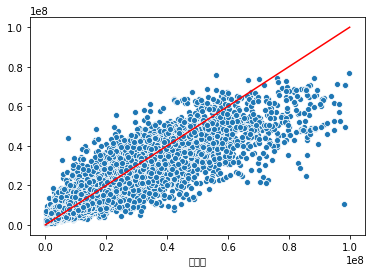

In [90]:
sns.scatterplot(y_test, pred_log_T)
mape(y_test, pred_log_T)
sns.lineplot(np.linspace(0,100000000,100),np.linspace(0,100000000,100),c='red',linestyle='--')

# Model4 (인간 그리드서치 가동)

**Parameters**
    * lr=0.1  md=5  n_est=100    39.676144140509386
    * lr=0.2  md=5  n_est=100    35.86271566334253
    * lr=0.3  md=5  n_est=100    34.523469899511724
    * lr=0.4  md=5  n_est=100    33.83086117952061
    * lr=0.5  md=5  n_est=100    33.6046265896861  >> best (learning_rate=0.5)
    * lr=0.6  md=5  n_est=100    33.60629744105705
    * lr=0.7  md=5  n_est=100    34.032401318221346
    * lr=0.8  md=5  n_est=100    34.46326278156654
    * lr=0.9  md=5  n_est=100    35.65708334014499
    * lr=1.0  md=5  n_est=100    37.01656351292716
    
    * lr=0.5  md=4  n_est=100    35.556284249874736
    * lr=0.5  md=6  n_est=100    32.49091180868051  >> best (max_depth=6)
    * lr=0.5  md=7  n_est=100    32.654291149263884
    * lr=0.5  md=7  n_est=100    33.16308701813581

    * lr=0.5  md=6  n_est=90    32.549430289185324
    * lr=0.5  md=6  n_est=110    32.40172798464047
    * lr=0.5  md=6  n_est=120    32.23694288540079
    * lr=0.5  md=6  n_est=130    32.00600070239064
    * lr=0.5  md=6  n_est=140    31.99805397706713
    * lr=0.5  md=6  n_est=150    32.00349820393516
    * lr=0.5  md=6  n_est=160    31.942708981458555
    * lr=0.5  md=6  n_est=170    31.865299576486382
    * lr=0.5  md=6  n_est=180    31.816496799997278
    * lr=0.5  md=6  n_est=190    31.770673026832302
    * lr=0.5  md=6  n_est=200    31.81436899901522
    * lr=0.5  md=6  n_est=210    31.825948426810736
    * lr=0.5  md=6  n_est=220    31.738559835106216
    * lr=0.5  md=6  n_est=230    31.705801965067167 >> best (n_estimators=230)
    * lr=0.5  md=6  n_est=240    31.788077879215344
    * lr=0.5  md=6  n_est=250    31.831044459751983
    
    * lr=0.5  md=6  n_est=250  cs_bt=1      31.705801965067167
    * lr=0.5  md=6  n_est=250  cs_bt=0.9    31.594474418352597
    * lr=0.5  md=6  n_est=250  cs_bt=0.8    31.884558879720366
    * lr=0.5  md=6  n_est=250  cs_bt=0.7    32.28889282234651
    * lr=0.5  md=6  n_est=250  cs_bt=0.6    31.888767390135435
    * lr=0.5  md=6  n_est=250  cs_bt=0.5    32.397858628770855
    * lr=0.5  md=6  n_est=250  cs_bt=0.4    31.962034755645526
    * lr=0.5  md=6  n_est=250  cs_bt=0.3    31.39365410753319
    * lr=0.5  md=6  n_est=250  cs_bt=0.2    31.71222069543878
    * lr=0.5  md=6  n_est=250  cs_bt=0.1    31.57699918844068 >> best(colsample_bytree=0.1) ...? estimator가 너무 많아서 그런가?


<여기부턴 규칙성이 없습니다. 인간 그리드서치가 꽂히는대로 바꿔봅니다. 모든 시행을 기록하지 않고, 점수가 좋아지는 경우만 기록합니다.>

    * lr=0.2  md=6  n_est=250  cs_bt=1    30.858997015452516
    * lr=0.2  md=7  n_est=250  cs_bt=1    30.240123547611503
    * lr=0.2  md=7  n_est=250  cs_bt=0.2    30.19838012420267
    * lr=0.2  md=7  n_est=250  cs_bt=0.3    30.072913793484563
    * lr=0.2  md=7  n_est=260  cs_bt=0.3    29.98115149841886
    * lr=0.25  md=7  n_est=260  cs_bt=0.3    29.881961250427363
    * lr=0.25  md=7  n_est=260  cs_bt=0.31    29.875803781959725
    * lr=0.253  md=7  n_est=260  cs_bt=0.31    29.862564916199354
    * lr=0.247  md=7  n_est=260  cs_bt=0.31    29.84555474938013
    * lr=0.247  md=7  n_est=270  cs_bt=0.31    29.806075507451794
    * lr=0.247  md=7  n_est=280  cs_bt=0.31    29.76580952085039
    * lr=0.247  md=7  n_est=290  cs_bt=0.31    29.71998662544207
    * lr=0.247  md=7  n_est=300  cs_bt=0.31    29.67707806509011 >> n_estimator가 많아지면서 다수 저렴한 상품에 과적합되면서 MAPE가 교정되는 듯 합니다.
    * lr=0.247  md=7  n_est=310  cs_bt=0.31    29.661149146723094  
    * lr=0.247  md=7  n_est=320  cs_bt=0.31    29.609695080183506
    * lr=0.247  md=7  n_est=330  cs_bt=0.31    29.608322413574733
    * lr=0.247  md=7  n_est=330  cs_bt=0.30    29.590688232359746










    
    

31.460430511208532

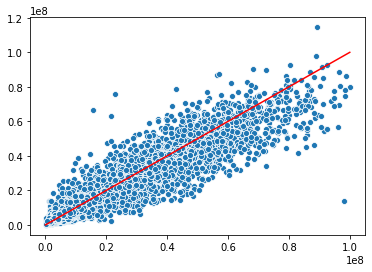

In [51]:
from xgboost import plot_importance
from xgboost import XGBRegressor

xgb2 = XGBRegressor(learning_rate=0.247,
                  max_depth=7,
                  n_estimators=330,
                    colsample_bytree=0.3,
                  random_state=529)
xgb2.fit(X_train,y_train_log)

pred_log = xgb2.predict(X_test)
pred_log_T = np.exp(1)**pred_log

sns.scatterplot(y_test, pred_log_T)

sns.lineplot(np.linspace(0,100000000,100),np.linspace(0,100000000,100),c='red',linestyle='--')

mape(y_test, pred_log_T)

In [92]:
len(train['상품명'].unique())

1682

In [94]:
train.groupby('방송일시_dow')['취급액'].mean()

방송일시_dow
0    2.179913e+07
1    2.146270e+07
2    2.185882e+07
3    2.183548e+07
4    2.154999e+07
5    2.488452e+07
6    2.462156e+07
Name: 취급액, dtype: float64

In [ ]:
df_all.